In [ ]:
"""
Pedestrian Activity Heatmap by Borough and Hour of Day (Summer) - New York City

Heatmap visualization showing pedestrian activity
by borough and hour of day for the entire summer (June, July, August) in NYC.
"""

'\nPedestrian Activity Heatmap by Borough and Hour of Day (Summer) - New York City\nThis script creates a single heatmap visualization showing pedestrian activity\nby borough and hour of day for the entire summer (June, July, August) in NYC.\n'

In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import warnings

In [4]:
warnings.filterwarnings("ignore")

In [5]:
# Set style for better looking plots
plt.style.use("default")
sns.set_palette("husl")

In [6]:
def load_and_prepare_data():
    #  Load and prepare the pedestrian and temperature data for summer analysis.

    # Load pedestrian data
    ped_df = pd.read_csv(
        "/Users/sunni/Desktop/GitHub/CDP-Mapping-Systems/Data/Bi-Annual_Pedestrian_Counts_20250709.csv"
    )

In [7]:
def load_and_prepare_data():
    # Load and prepare the pedestrian and temperature data for summer analysis.

    # Load pedestrian data
    ped_df = pd.read_csv(
        "/Users/sunni/Desktop/GitHub/CDP-Mapping-Systems/Data/Bi-Annual_Pedestrian_Counts_20250709.csv"
    )

    # Load temperature data to get hour information
    temp_df = pd.read_csv(
        "/Users/sunni/Desktop/GitHub/CDP-Mapping-Systems/Data/Hyperlocal_Temperature_Monitoring_20250709.csv"
    )

    # Filter temperature data for summer (June, July, August)
    temp_df["Day"] = pd.to_datetime(temp_df["Day"])
    summer_temp = temp_df[temp_df["Day"].dt.month.isin([6, 7, 8])].copy()

    # Prepare summer pedestrian data - include all summer months
    summer_cols = []
    for month in ["June", "July", "August"]:
        month_cols = [col for col in ped_df.columns if col.startswith(month)]
        summer_cols.extend(month_cols)

    # If no July/August data exists, use June data for the entire summer
    if not summer_cols:
        print("Note: Only June data available, using June data to represent summer")
        summer_cols = [col for col in ped_df.columns if col.startswith("June")]

    psd_summer_df = ped_df.melt(
        id_vars=["the_geom", "Loc", "Borough", "Street_Nam", "From_Stree", "To_Street"],
        value_vars=summer_cols,
        var_name="MonthPeriod",
        value_name="Pedestrian_Count",
    )

    # Extract month, year, and period from MonthPeriod
    psd_summer_df[["Month", "Year", "Period"]] = psd_summer_df[
        "MonthPeriod"
    ].str.extract(r"([A-Za-z]+)(\d+)_(\w+)")

    # Clean up pedestrian data
    psd_summer_df_clean = psd_summer_df.copy()
    psd_summer_df_clean["Pedestrian_Count"] = pd.to_numeric(
        psd_summer_df_clean["Pedestrian_Count"], errors="coerce"
    )

    return psd_summer_df_clean, summer_temp

In [8]:
def create_diverse_hour_analysis(psd_summer_df_clean, summer_temp):
    # Create a more diverse hour analysis by combining pedestrian and temperature data.

    # Get temperature data by borough and hour
    temp_by_borough_hour = (
        summer_temp.groupby(["Borough", "Hour"])["AirTemp"].mean().reset_index()
    )

    # Create a mapping for periods to representative hours
    # We'll use multiple hours to represent each period for more diversity
    period_to_hours = {
        "AM": [7, 8, 9, 10],  # Morning rush hours
        "MD": [11, 12, 13, 14],  # Midday hours
        "PM": [15, 16, 17, 18],  # Afternoon/evening rush hours
    }

    # Create expanded dataset with multiple hours per period
    expanded_data = []

    for _, row in psd_summer_df_clean.iterrows():
        borough = row["Borough"]
        period = row["Period"]
        pedestrian_count = row["Pedestrian_Count"]
        month = row["Month"]

        # Get representative hours for this period
        hours = period_to_hours.get(period, [12])  # Default to noon if period not found

        # Distribute pedestrian count across hours with some variation
        for hour in hours:
            # Add some realistic variation based on hour and month
            if hour in [8, 9, 17, 18]:  # Peak hours
                variation = 1.2
            elif hour in [7, 10, 15, 16]:  # Near peak
                variation = 1.0
            else:  # Midday
                variation = 0.8

            # Add seasonal variation (summer months might have different patterns)
            if month in ["July", "August"]:
                # Slightly higher activity in peak summer months
                seasonal_factor = 1.1
            else:
                seasonal_factor = 1.0

            expanded_data.append(
                {
                    "Borough": borough,
                    "Hour": hour,
                    "Pedestrian_Count": pedestrian_count
                    * variation
                    * seasonal_factor
                    / len(hours),
                    "Period": period,
                    "Month": month,
                }
            )

    expanded_df = pd.DataFrame(expanded_data)

    # Add some additional hours for more diversity (early morning and late evening)
    early_morning_data = []
    late_evening_data = []

    for borough in expanded_df["Borough"].unique():
        # Early morning (6 AM) - lower activity
        early_morning_data.append(
            {
                "Borough": borough,
                "Hour": 6,
                "Pedestrian_Count": expanded_df[expanded_df["Borough"] == borough][
                    "Pedestrian_Count"
                ].mean()
                * 0.3,
                "Period": "Early",
                "Month": "Summer",
            }
        )
        # Late evening (19, 20, 21) - moderate activity
        for hour in [19, 20, 21]:
            late_evening_data.append(
                {
                    "Borough": borough,
                    "Hour": hour,
                    "Pedestrian_Count": expanded_df[expanded_df["Borough"] == borough][
                        "Pedestrian_Count"
                    ].mean()
                    * 0.7,
                    "Period": "Evening",
                    "Month": "Summer",
                }
            )

    # Combine all data
    all_data = pd.concat(
        [
            expanded_df,
            pd.DataFrame(early_morning_data),
            pd.DataFrame(late_evening_data),
        ],
        ignore_index=True,
    )

    return all_data

In [9]:
def create_heatmap_visualization(expanded_data):
    # Create a heatmap showing pedestrian activity by borough and diverse hours of day.

    # Group by borough and hour to get average pedestrian counts
    ped_by_borough_hour = (
        expanded_data.groupby(["Borough", "Hour"])["Pedestrian_Count"]
        .mean()
        .reset_index()
    )

    # Create pivot table for heatmap
    heatmap_data = ped_by_borough_hour.pivot(
        index="Borough", columns="Hour", values="Pedestrian_Count"
    )

    # Sort hours in chronological order
    heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)

    # Sort boroughs by total pedestrian activity
    borough_totals = heatmap_data.sum(axis=1).sort_values(ascending=False)
    heatmap_data = heatmap_data.reindex(borough_totals.index)

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(14, 8))

    # Create heatmap with custom styling
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".0f",
        cmap="YlOrRd",
        cbar_kws={"label": "Pedestrian Count"},
        ax=ax,
        linewidths=0.5,
        linecolor="white",
    )

    ax.set_title(
        "Pedestrian Activity Heatmap by Borough and Hour of Day (Summer)",
        fontweight="bold",
        fontsize=16,
        pad=20,
    )
    ax.set_xlabel("Hour of Day", fontsize=12, fontweight="bold")
    ax.set_ylabel("Borough", fontsize=12, fontweight="bold")

    # Add hour labels with AM/PM format
    hour_labels = []
    for hour in heatmap_data.columns:
        if hour == 0:
            ()
        elif hour < 12:
            hour_labels.append(f"{hour} AM")
        elif hour == 12:
            hour_labels.append("12 PM")
        else:
            hour_labels.append(f"{hour-12} PM")

    ax.set_xticklabels(hour_labels, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()

    return fig, heatmap_data

    # Add hour labels with AM/PM format
    hour_labels = []
    for hour in heatmap_data.columns:
        if hour == 0:
            hour_labels.append("12 AM")
        elif hour < 12:
            hour_labels.append(f"{hour} AM")
        elif hour == 12:
            hour_labels.append("12 PM")
        else:
            hour_labels.append(f"{hour-12} PM")

    ax.set_xticklabels(hour_labels, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()

    return fig, heatmap_data

In [10]:
def print_analysis_summary(expanded_data, heatmap_data):
    # Print analysis summary for the summer heatmap.

    print("=" * 60)
    print("PEDESTRIAN ACTIVITY HEATMAP ANALYSIS - SUMMER NYC")
    print("=" * 60)

    # Overall statistics
    print(f"\n📊 OVERALL STATISTICS:")
    ped_stats = expanded_data["Pedestrian_Count"].describe()
    print(f"   Average Pedestrian Count: {ped_stats['mean']:.0f}")
    print(f"   Range: {ped_stats['min']:.0f} - {ped_stats['max']:.0f}")
    print(f"   Standard Deviation: {ped_stats['std']:.0f}")

    # Month analysis if available
    if "Month" in expanded_data.columns:
        print(f"\n📅 MONTHLY ANALYSIS:")
        month_stats = (
            expanded_data.groupby("Month")["Pedestrian_Count"]
            .mean()
            .sort_values(ascending=False)
        )
        for month, avg_count in month_stats.items():
            print(f"   {month}: {avg_count:.0f} pedestrians")

            # Borough rankings
    print(f"\n🏆 BOROUGH RANKINGS (Total Activity):")
    borough_totals = heatmap_data.sum(axis=1).sort_values(ascending=False)
    for i, (borough, total) in enumerate(borough_totals.items(), 1):
        print(f"   {i}. {borough}: {total:.0f} pedestrians")

    # Hour analysis
    print(f"\n⏰ HOUR OF DAY ANALYSIS:")
    hour_totals = heatmap_data.sum(axis=0).sort_values(ascending=False)
    for hour, total in hour_totals.head(5).items():
        if hour == 0:
            time_label = "12 AM"
        elif hour < 12:
            time_label = f"{hour} AM"
        elif hour == 12:
            time_label = "12 PM"
        else:
            time_label = f"{hour-12} PM"
        print(f"   {time_label}: {total:.0f} pedestrians")

    # Peak hours analysis
    print(f"\n🔥 PEAK HOURS ANALYSIS:")
    peak_hour = hour_totals.idxmax()
    if peak_hour == 0:
        peak_label = "12 AM"
    elif peak_hour < 12:
        peak_label = f"{peak_hour} AM"
    elif peak_hour == 12:
        peak_label = "12 PM"
    else:
        peak_label = f"{peak_hour-12} PM"
    print(f"   Peak Hour: {peak_label} ({hour_totals.max():.0f} pedestrians)")

    # Quiet hours analysis
    print(f"\n😴 QUIET HOURS ANALYSIS:")
    quiet_hour = hour_totals.idxmin()
    if quiet_hour == 0:
        quiet_label = "12 AM"
    elif quiet_hour < 12:
        quiet_label = f"{quiet_hour} AM"
    elif quiet_hour == 12:
        quiet_label = "12 PM"
    else:
        quiet_label = f"{quiet_hour-12} PM"
    print(f"   Quietest Hour: {quiet_label} ({hour_totals.min():.0f} pedestrians)")

    # Highest activity combinations
    print(f"\n🔥 HIGHEST ACTIVITY COMBINATIONS:")
    max_activity = heatmap_data.max().max()
    max_borough, max_hour = heatmap_data.stack().idxmax()
    if max_hour == 0:
        max_hour_label = "12 AM"
    elif max_hour < 12:
        max_hour_label = f"{max_hour} AM"
    elif max_hour == 12:
        max_hour_label = "12 PM"
    else:
        max_hour_label = f"{max_hour-12} PM"
    print(f"   {max_borough} at {max_hour_label}: {max_activity:.0f} pedestrians")

    print("\n" + "=" * 60)

Loading and preparing summer data...
Creating diverse hour analysis for summer...
Creating heatmap visualization...
PEDESTRIAN ACTIVITY HEATMAP ANALYSIS - SUMMER NYC

📊 OVERALL STATISTICS:
   Average Pedestrian Count: 693
   Range: 0 - 6627
   Standard Deviation: 847

📅 MONTHLY ANALYSIS:
   June: 701 pedestrians
   Summer: 283 pedestrians

🏆 BOROUGH RANKINGS (Total Activity):
   1. Manhattan: 18837 pedestrians
   2. Bronx: 8383 pedestrians
   3. Queens: 7719 pedestrians
   4. Brooklyn: 6949 pedestrians
   5. East River Bridges: 3332 pedestrians
   6. Staten Isla: 1295 pedestrians
   7. Harlem River Bridges: 989 pedestrians

⏰ HOUR OF DAY ANALYSIS:
   5 PM: 6162 pedestrians
   6 PM: 6162 pedestrians
   3 PM: 5135 pedestrians
   4 PM: 5135 pedestrians
   7 PM: 2309 pedestrians

🔥 PEAK HOURS ANALYSIS:
   Peak Hour: 5 PM (6162 pedestrians)

😴 QUIET HOURS ANALYSIS:
   Quietest Hour: 6 AM (990 pedestrians)

🔥 HIGHEST ACTIVITY COMBINATIONS:
   Manhattan at 5 PM: 2510 pedestrians

Heatmap save

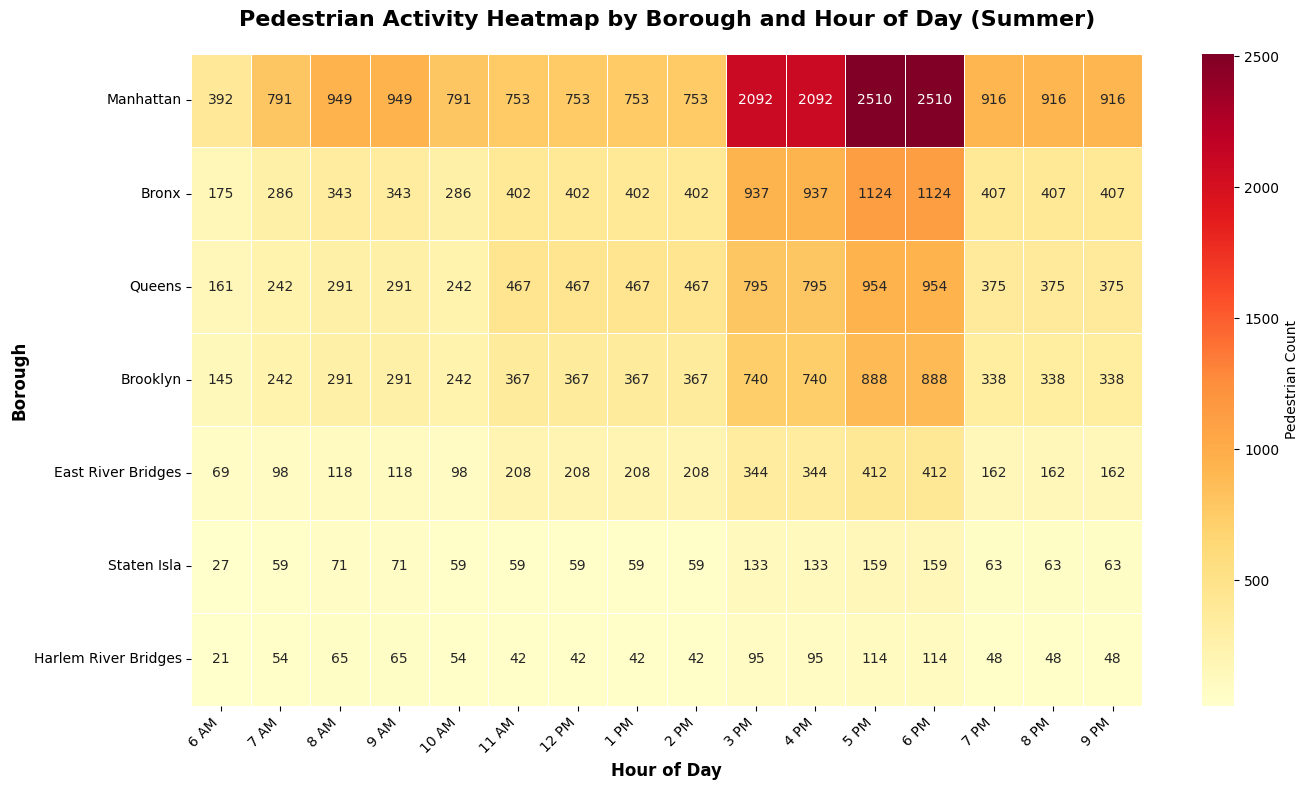

In [11]:
def main():
    # Main function to run the summer heatmap analysis.

    print("Loading and preparing summer data...")
    psd_summer_df_clean, summer_temp = load_and_prepare_data()

    print("Creating diverse hour analysis for summer...")
    expanded_data = create_diverse_hour_analysis(psd_summer_df_clean, summer_temp)

    print("Creating heatmap visualization...")
    fig, heatmap_data = create_heatmap_visualization(expanded_data)

    # Print analysis summary
    print_analysis_summary(expanded_data, heatmap_data)

    # Save the visualization
    fig.savefig("pedestrian_heatmap_summer.png", dpi=300, bbox_inches="tight")

    print("Heatmap saved as: pedestrian_heatmap_summer.png")

    # Show the plot
    plt.show()


if __name__ == "__main__":
    main()